In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from xgboost import XGBRegressor
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
%matplotlib inline

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
df=pd.read_csv("train.csv")
df.head()

,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,no_of_CTA,mean_CTA_len,is_image,is_personalised,is_quote,is_timer,is_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate
0,1,3,76,10439,39,5,1,Noon,6,26,3,29,0,0,0,0,0,0,0,0,14,0.103079
1,2,3,54,2570,256,5,1,Morning,2,11,0,22,0,0,0,0,0,0,0,0,10,0.700000
2,3,3,59,12801,16,5,1,Noon,2,11,3,23,1,0,1,0,0,0,0,0,16,0.002769
3,4,3,74,11037,30,4,0,Evening,15,9,4,24,0,0,0,0,0,0,0,0,10,0.010868
4,5,3,80,10011,27,5,1,Noon,6,26,3,31,0,0,1,0,0,0,0,0,14,0.142826


In [4]:
df.shape

(1888, 22)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888 entries, 0 to 1887
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   campaign_id         1888 non-null   int64  
 1   sender              1888 non-null   int64  
 2   subject_len         1888 non-null   int64  
 3   body_len            1888 non-null   int64  
 4   mean_paragraph_len  1888 non-null   int64  
 5   day_of_week         1888 non-null   int64  
 6   is_weekend          1888 non-null   int64  
 7   times_of_day        1888 non-null   object 
 8   category            1888 non-null   int64  
 9   product             1888 non-null   int64  
 10  no_of_CTA           1888 non-null   int64  
 11  mean_CTA_len        1888 non-null   int64  
 12  is_image            1888 non-null   int64  
 13  is_personalised     1888 non-null   int64  
 14  is_quote            1888 non-null   int64  
 15  is_timer            1888 non-null   int64  
 16  is_emo

In [6]:
df_test=pd.read_csv('test.csv')
df_test.head()

,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,no_of_CTA,mean_CTA_len,is_image,is_personalised,is_quote,is_timer,is_emoticons,is_discount,is_price,is_urgency,target_audience
0,1889,3,61,12871,11,6,1,Noon,6,26,3,37,1,0,0,0,1,0,0,0,14
1,1890,3,54,2569,256,5,1,Morning,2,11,0,22,0,0,0,0,0,0,0,0,10
2,1891,3,88,1473,78,4,0,Evening,2,11,0,22,1,0,1,0,0,0,0,0,10
3,1892,3,88,1473,78,3,0,Evening,2,11,0,22,1,0,1,0,0,0,0,0,10
4,1893,3,78,9020,29,3,0,Noon,6,26,2,40,0,0,0,0,0,0,0,0,14


# Looking for missing values

In [7]:
missing = pd.DataFrame()
missing["sum"]=df.isna().sum()
missing["percentage"]= df.isna().mean() * 100
missing=missing[missing["sum"]>0].sort_values(ascending=False,by='sum')
missing

,sum,percentage


* so no missing values
* looking into head i can say campain_id is not so useful so drop it

In [8]:
df.drop("campaign_id",axis=1,inplace=True)

In [9]:
df.head()

,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,no_of_CTA,mean_CTA_len,is_image,is_personalised,is_quote,is_timer,is_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate
0,3,76,10439,39,5,1,Noon,6,26,3,29,0,0,0,0,0,0,0,0,14,0.103079
1,3,54,2570,256,5,1,Morning,2,11,0,22,0,0,0,0,0,0,0,0,10,0.700000
2,3,59,12801,16,5,1,Noon,2,11,3,23,1,0,1,0,0,0,0,0,16,0.002769
3,3,74,11037,30,4,0,Evening,15,9,4,24,0,0,0,0,0,0,0,0,10,0.010868
4,3,80,10011,27,5,1,Noon,6,26,3,31,0,0,1,0,0,0,0,0,14,0.142826


* we will split data into `x,y` and `x` further into `continuios, catagorical and boolean` data 

In [10]:
x=df.drop("click_rate",axis=1)
y=df.click_rate

In [11]:
unique=[]
bool_col=[]
cat_col=[]
cont_col =[]

In [12]:
for i in x.columns:
    n_values = x[i].nunique()
    if n_values==1:
        unique.append(i)
    elif n_values == 2:
        bool_col.append(i)
    elif n_values < 10:
        cat_col.append(i)
    else:
        cont_col.append(i)

In [13]:
print("Unique columns in the data are :",unique,end='\n \n')
print("Boolean columns in the data are :",bool_col,end='\n \n')
print("Catagorical columns in the data are :",cat_col,end='\n \n')
print("Continuious columns in the data are :",cont_col,end='\n \n')

Unique columns in the data are : ['is_timer']
 
Boolean columns in the data are : ['is_weekend', 'is_personalised', 'is_discount', 'is_urgency']
 
Catagorical columns in the data are : ['day_of_week', 'times_of_day', 'is_image', 'is_quote', 'is_emoticons', 'is_price']
 
Continuious columns in the data are : ['sender', 'subject_len', 'body_len', 'mean_paragraph_len', 'category', 'product', 'no_of_CTA', 'mean_CTA_len', 'target_audience']
 


In [14]:
x.drop(unique,axis=1,inplace=True)

In [15]:
df_test.drop(unique,axis=1,inplace=True)

In [16]:
x.head()

,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,no_of_CTA,mean_CTA_len,is_image,is_personalised,is_quote,is_emoticons,is_discount,is_price,is_urgency,target_audience
0,3,76,10439,39,5,1,Noon,6,26,3,29,0,0,0,0,0,0,0,14
1,3,54,2570,256,5,1,Morning,2,11,0,22,0,0,0,0,0,0,0,10
2,3,59,12801,16,5,1,Noon,2,11,3,23,1,0,1,0,0,0,0,16
3,3,74,11037,30,4,0,Evening,15,9,4,24,0,0,0,0,0,0,0,10
4,3,80,10011,27,5,1,Noon,6,26,3,31,0,0,1,0,0,0,0,14


In [17]:
x.shape

(1888, 19)

# boolean Data

In [18]:
x[bool_col].head()

,is_weekend,is_personalised,is_discount,is_urgency
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,0,0,0,0
4,1,0,0,0


# Catagorical Columns

In [19]:
x[cat_col].head()

,day_of_week,times_of_day,is_image,is_quote,is_emoticons,is_price
0,5,Noon,0,0,0,0
1,5,Morning,0,0,0,0
2,5,Noon,1,1,0,0
3,4,Evening,0,0,0,0
4,5,Noon,0,1,0,0


* `day_of_week,is_image, is_quote, is_emotiocons` looks numerial but still it is undr catagorical section
* `is_price` looks boolean but are in catagorical section 
* lets analyze the data'

<AxesSubplot:xlabel='day_of_week', ylabel='count'>

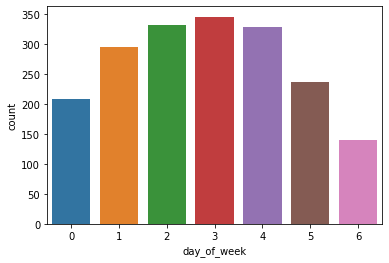

In [20]:
sns.countplot(x=x.day_of_week)

<AxesSubplot:xlabel='day_of_week', ylabel='click_rate'>

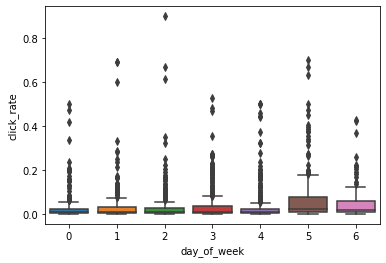

In [21]:
sns.boxplot(x=x.day_of_week,y=y)

* Though it looks numerical data it is actually catagorical by nature 
* so we will convert tthis to catagorical data

In [22]:
x.day_of_week=x.day_of_week.astype('object')

In [23]:
df_test.day_of_week=df_test.day_of_week.astype('object')

/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_image', ylabel='count'>

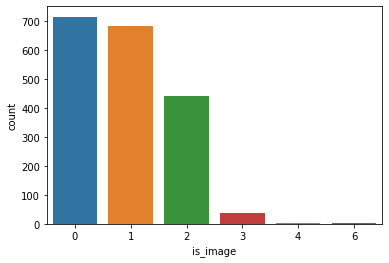

In [24]:
# is_image
sns.countplot(x.is_image)

* is_image if no of image >2 is very minor in share so we will group them as a feature

In [25]:
x.is_image= x.is_image.apply(lambda x: 3 if x>2 else x)
df_test.is_image=df_test.is_image.apply(lambda x: 3 if x>2 else x)

/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_image', ylabel='count'>

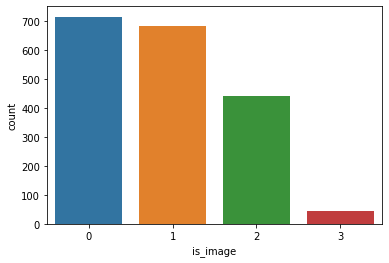

In [26]:
sns.countplot(x.is_image)

/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_quote', ylabel='count'>

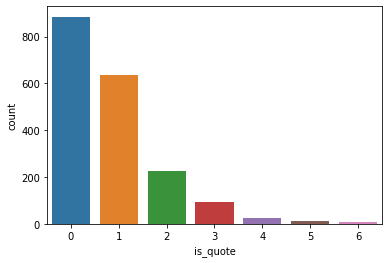

In [27]:
# is_quote
sns.countplot(x.is_quote)

* if is_quote> 3 we will group them as feature we will impute 100 as other option to have an understanding

In [28]:
x.is_quote =x.is_quote.apply(lambda x: 100 if x>3 else x)
df_test.is_quote=df_test.is_quote.apply(lambda x: 100 if x>3 else x)

/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_quote', ylabel='count'>

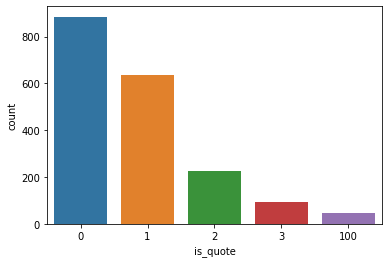

In [29]:
sns.countplot(x.is_quote)

/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_emoticons', ylabel='count'>

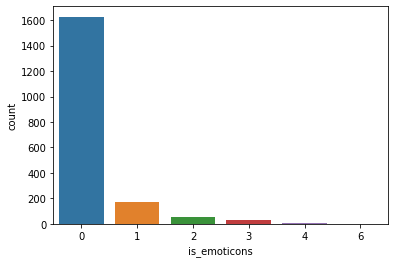

In [30]:
# is_emoticons
sns.countplot(x.is_emoticons)

* data is very skewed we will make  is if 0 else 1

In [31]:
x.is_emoticons = x.is_emoticons.apply(lambda x : 0 if x==0 else 1)
df_test.is_emoticons=df_test.is_emoticons.apply(lambda x : 0 if x==0 else 1)

/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_emoticons', ylabel='count'>

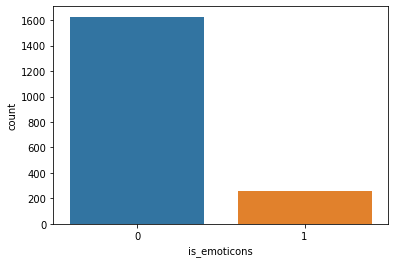

In [32]:
sns.countplot(x.is_emoticons)

* converting day_of_week,is_image, is_quote, is_emotiocons to object type

In [33]:
# day_of_week, is_image, is_quote, is_emotiocons
x[["is_image", "is_quote", "is_emoticons"]] =x[["is_image", "is_quote", "is_emoticons"]].astype('object')
df_test[["is_image", "is_quote", "is_emoticons"]]=df_test[["is_image", "is_quote", "is_emoticons"]].astype('object')

/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_price', ylabel='count'>

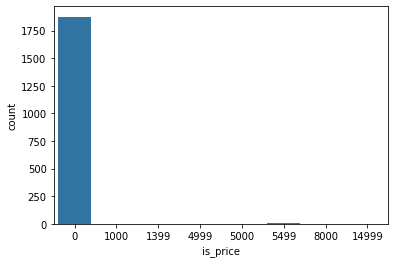

In [34]:
# is_image
sns.countplot(x.is_price)

/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_price', ylabel='count'>

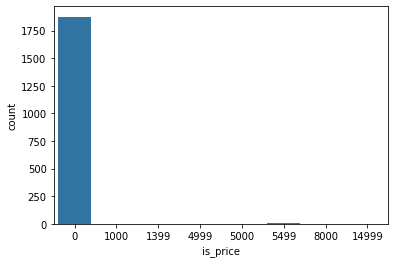

In [35]:
# is_image
sns.countplot(x.is_price)

In [36]:
x.is_price.value_counts(normalize=True)

0        0.993114
5499     0.002648
8000     0.001059
5000     0.001059
4999     0.000530
1399     0.000530
1000     0.000530
14999    0.000530
Name: is_price, dtype: float64

* looking into the data the is totally useless as the data is highly skewed so we will drop it 

In [37]:
x.drop('is_price',axis=1,inplace=True)
df_test.drop('is_price',axis=1,inplace=True)
cat_col.remove('is_price')

* we will One hot encode other varibales later we will perform rfe to select kbest out of them

In [38]:
x[cat_col].head()

,day_of_week,times_of_day,is_image,is_quote,is_emoticons
0,5,Noon,0,0,0
1,5,Morning,0,0,0
2,5,Noon,1,1,0
3,4,Evening,0,0,0
4,5,Noon,0,1,0


In [39]:
for i in cat_col:
    dummy=pd.get_dummies(x[i],prefix=i)
    x= pd.concat([x,dummy],axis=1)
    test_dummy=pd.get_dummies(df_test[i],prefix=i)
    df_test = pd.concat([df_test,test_dummy],axis=1)
    x.drop(i,axis=1,inplace=True)
    df_test.drop(i,axis=1,inplace=True)            

/home/thecybermonster/.local/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/home/thecybermonster/.local/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/home/thecybermonster/.local/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/home/thecybermonster/.local/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype 

In [40]:
x.head()

,sender,subject_len,body_len,mean_paragraph_len,is_weekend,category,product,no_of_CTA,mean_CTA_len,is_personalised,is_discount,is_urgency,target_audience,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,times_of_day_Evening,times_of_day_Morning,times_of_day_Noon,is_image_0,is_image_1,is_image_2,is_image_3,is_quote_0,is_quote_1,is_quote_2,is_quote_3,is_quote_100,is_emoticons_0,is_emoticons_1
0,3,76,10439,39,1,6,26,3,29,0,0,0,14,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0
1,3,54,2570,256,1,2,11,0,22,0,0,0,10,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0
2,3,59,12801,16,1,2,11,3,23,0,0,0,16,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
3,3,74,11037,30,0,15,9,4,24,0,0,0,10,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0
4,3,80,10011,27,1,6,26,3,31,0,0,0,14,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0


In [41]:
x.shape

(1888, 34)

# continuious data

In [42]:
x[cont_col].head()

,sender,subject_len,body_len,mean_paragraph_len,category,product,no_of_CTA,mean_CTA_len,target_audience
0,3,76,10439,39,6,26,3,29,14
1,3,54,2570,256,2,11,0,22,10
2,3,59,12801,16,2,11,3,23,16
3,3,74,11037,30,15,9,4,24,10
4,3,80,10011,27,6,26,3,31,14


/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sender', ylabel='count'>

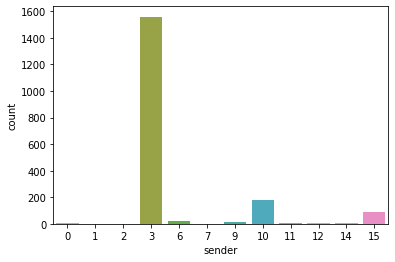

In [43]:
sns.countplot(x.sender)

* though the data looks continuious it acts catagorical and is skewed
* we will group 2, 10, 15 and all other as 1 

In [44]:
x.sender= x.sender.apply(lambda x: 100 if x not in [3,10,15] else x )

In [45]:
df_test.sender=df_test.sender.apply(lambda x: 100 if x not in [3,10,15] else x )

/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sender', ylabel='count'>

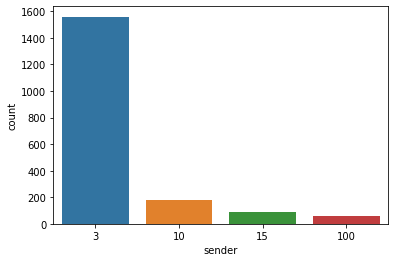

In [46]:
sns.countplot(x.sender)

In [47]:
x.sender=x.sender.astype('object')
df_test.sender=df_test.sender.astype('object')

In [48]:
dummy=pd.get_dummies(x.sender,prefix='sender')
x=pd.concat([x,dummy],axis=1)
x.drop('sender',axis=1,inplace=True)

/home/thecybermonster/.local/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [49]:
dummy=pd.get_dummies(df_test.sender,prefix='sender')
df_test=pd.concat([df_test,dummy],axis=1)
df_test.drop('sender',axis=1,inplace=True)

/home/thecybermonster/.local/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='subject_len'>

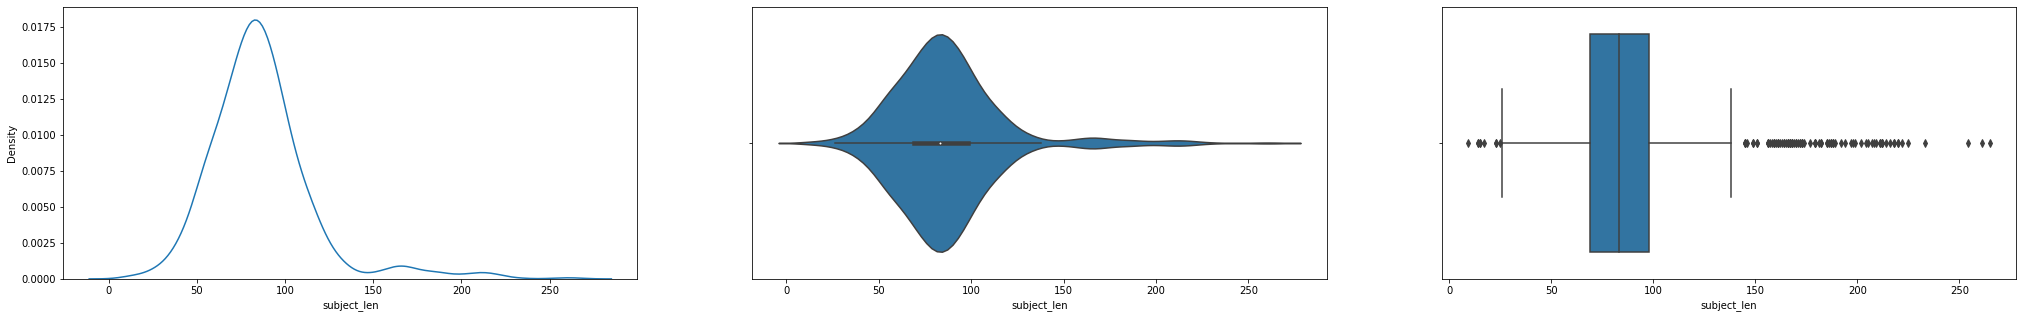

In [50]:
fig,axs= plt.subplots(ncols=3,figsize=(35,5))
sns.kdeplot(x.subject_len,ax=axs[0])
sns.violinplot(x.subject_len,ax=axs[1])
sns.boxplot(x.subject_len,ax=axs[2])

/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='body_len'>

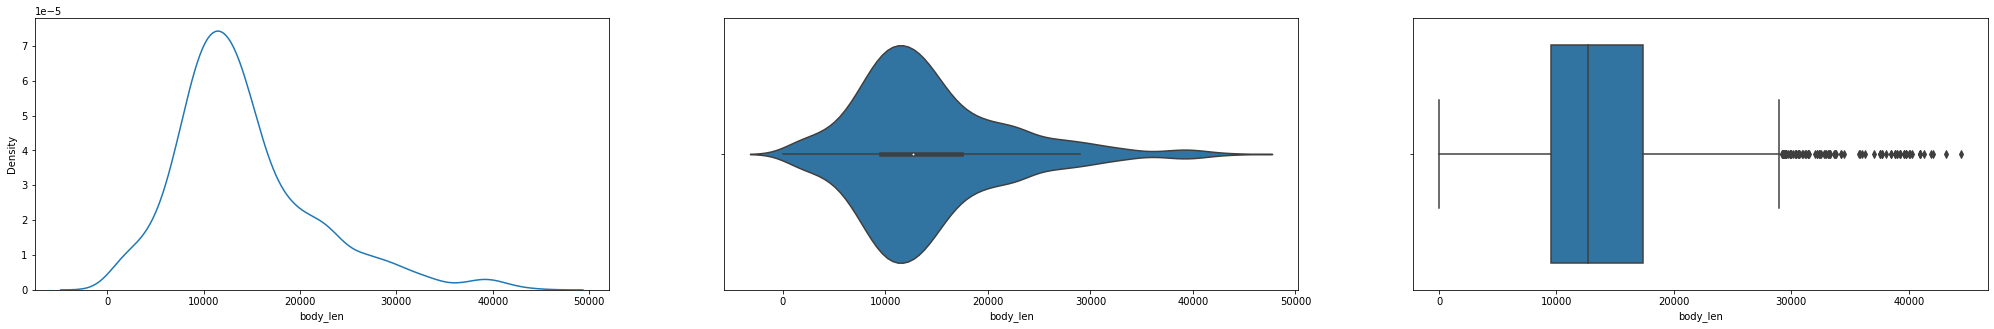

In [51]:
# body_len
fig,axs= plt.subplots(ncols=3,figsize=(35,5))
sns.kdeplot(x.body_len,ax=axs[0])
sns.violinplot(x.body_len,ax=axs[1])
sns.boxplot(x.body_len,ax=axs[2])

/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mean_paragraph_len'>

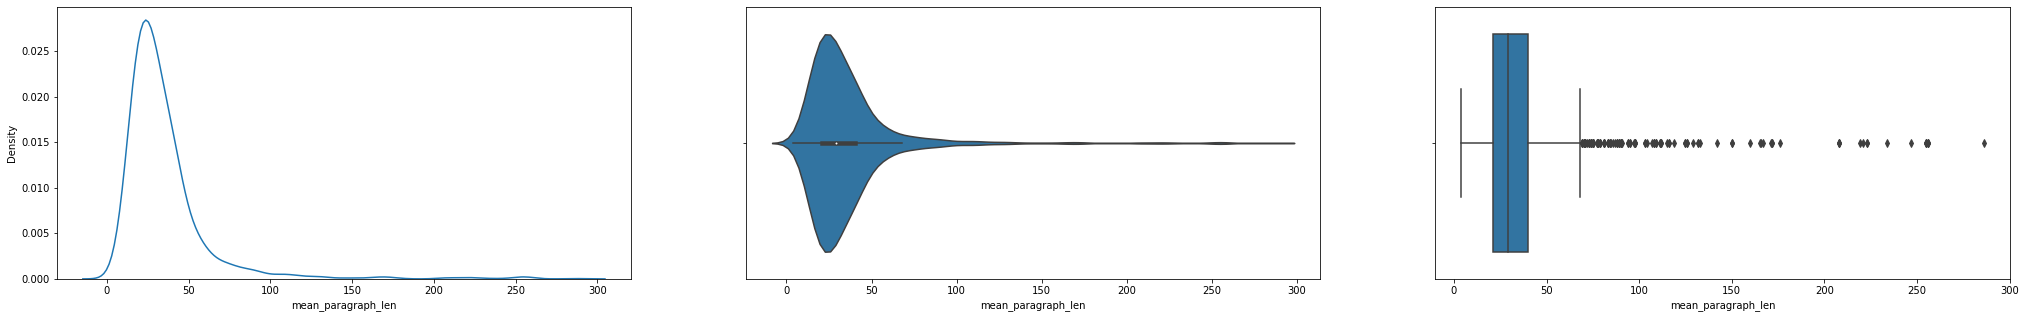

In [52]:
# mean_paragraph_len
fig,axs= plt.subplots(ncols=3,figsize=(35,5))
sns.kdeplot(x.mean_paragraph_len,ax=axs[0])
sns.violinplot(x.mean_paragraph_len,ax=axs[1])
sns.boxplot(x.mean_paragraph_len,ax=axs[2])

/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='category', ylabel='count'>

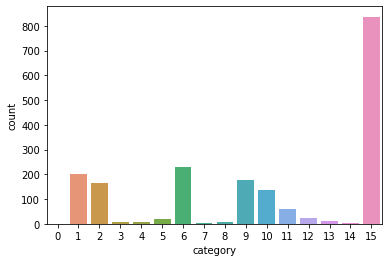

In [53]:
# Category
sns.countplot(x.category)

* we will goorup catagories with 1,2,6,9,10,15 and others

In [54]:
x.category = x.category.apply(lambda x: 100 if x not in [1,2,6,9,10,15] else x)
df_test.category=df_test.category.apply(lambda x: 100 if x not in [1,2,6,9,10,15] else x)

/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='category', ylabel='count'>

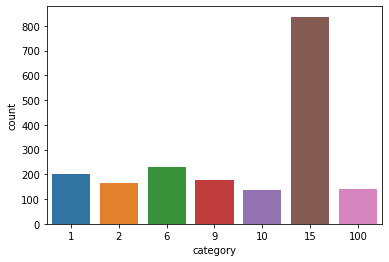

In [55]:
sns.countplot(x.category)

In [56]:
x.category=x.category.astype('object')
df_test.category=df_test.category.astype('object')

In [57]:
dummy=pd.get_dummies(x.category,prefix='category')
x=pd.concat([x,dummy],axis=1)
x.drop('category',axis=1,inplace=True)

/home/thecybermonster/.local/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [58]:
dummy=pd.get_dummies(df_test.category,prefix='category')
df_test=pd.concat([df_test,dummy],axis=1)
df_test.drop('category',axis=1,inplace=True)

/home/thecybermonster/.local/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='product'>

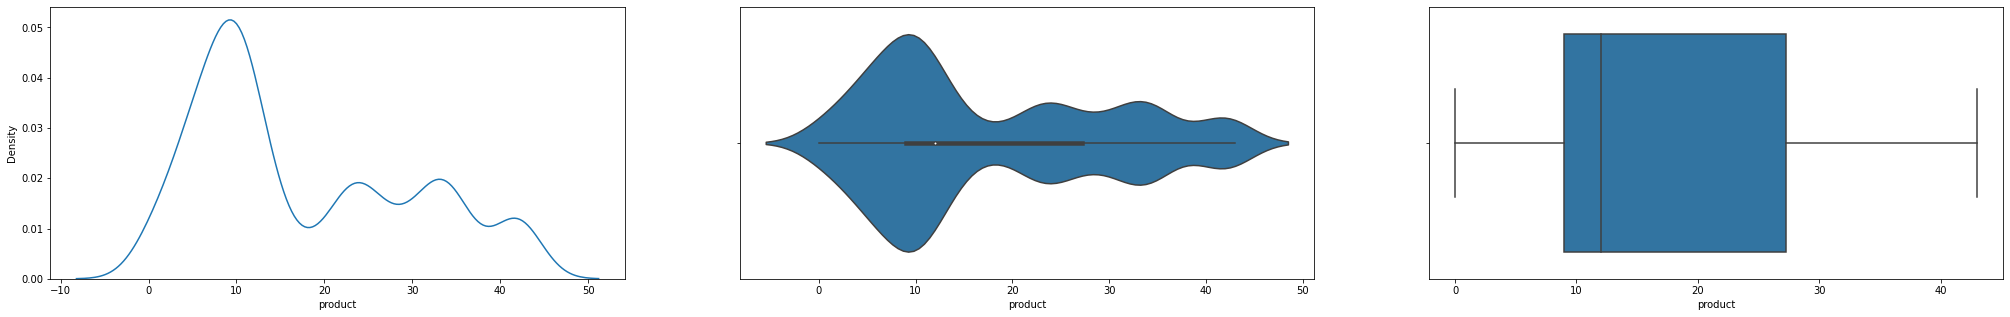

In [59]:
# mean_paragraph_len
fig,axs= plt.subplots(ncols=3,figsize=(35,5))
sns.kdeplot(x['product'],ax=axs[0])
sns.violinplot(x['product'],ax=axs[1])
sns.boxplot(x['product'],ax=axs[2])

* Looking at the kde plot and violen plot looks like catagorical data by nature

/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='product', ylabel='count'>

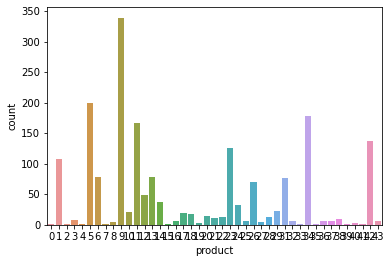

In [60]:
sns.countplot(x['product'])

* This is a catagorical varibale but it has 50 features
* we will convert them to binary but later point we will use RFE to reduce feture selection

In [61]:
prod=x['product'].value_counts().reset_index()
prod=prod[prod["product"] > 50]
prod=list(prod['index'])
prod

[9, 5, 34, 11, 42, 23, 1, 13, 6, 31, 26]

* now we use prod to transform the data

In [62]:
x['product']=x['product'].apply(lambda x: 100 if x not in prod else x)
df_test['product']=df_test['product'].apply(lambda x: 100 if x not in prod else x)

In [63]:
df_test['product']=df_test['product'].astype('object')
df_test['product']=df_test['product'].astype('object')

/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='product', ylabel='count'>

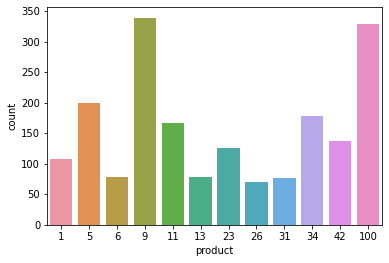

In [64]:
sns.countplot(x['product'])

In [65]:
dummy=pd.get_dummies(x['product'],prefix='product')
x=pd.concat([x,dummy],axis=1)
x.drop('product',axis=1,inplace=True)

In [66]:
dummy=pd.get_dummies(df_test['product'],prefix='product')
df_test=pd.concat([df_test,dummy],axis=1)
df_test.drop('product',axis=1,inplace=True)

/home/thecybermonster/.local/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='no_of_CTA'>

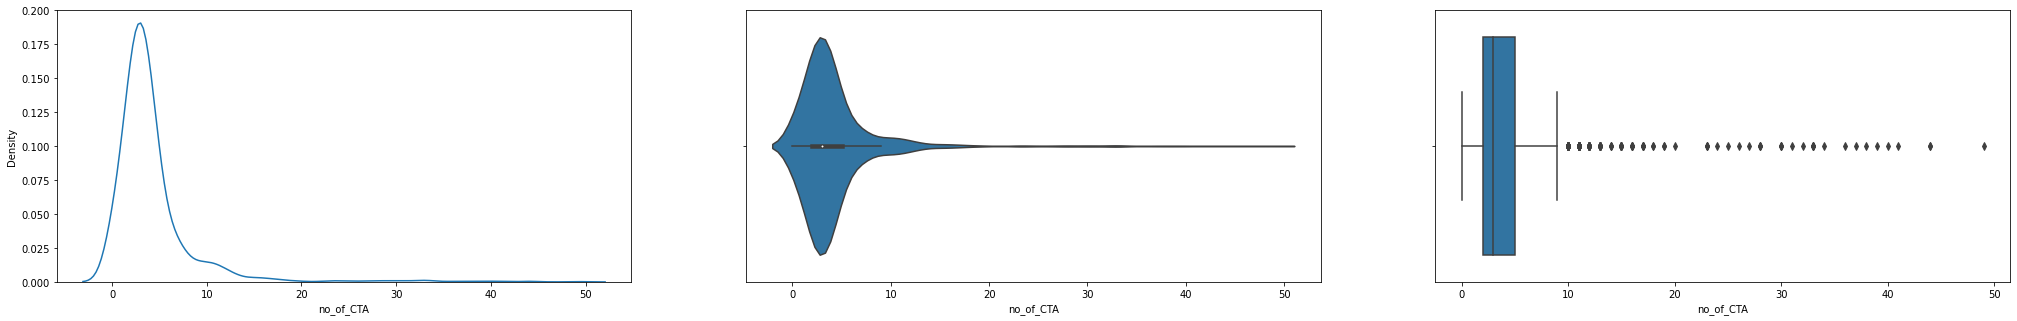

In [67]:
# no_of_CTA
fig,axs= plt.subplots(ncols=3,figsize=(35,5))
sns.kdeplot(x.no_of_CTA,ax=axs[0])
sns.violinplot(x.no_of_CTA,ax=axs[1])
sns.boxplot(x.no_of_CTA,ax=axs[2])

/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mean_CTA_len'>

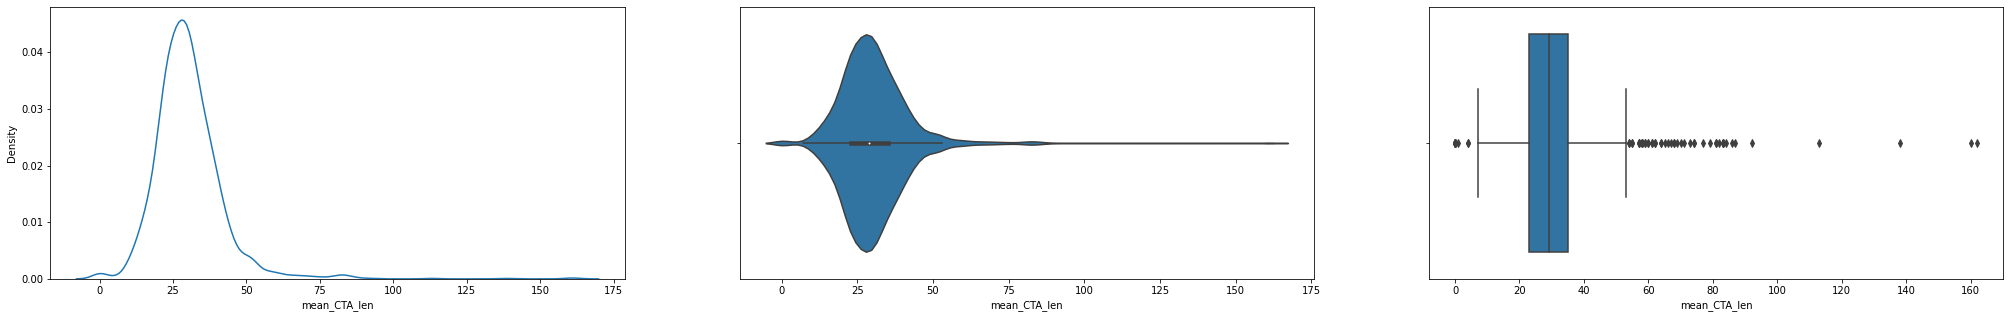

In [68]:
# mean_CTA_len
fig,axs= plt.subplots(ncols=3,figsize=(35,5))
sns.kdeplot(x.mean_CTA_len,ax=axs[0])
sns.violinplot(x.mean_CTA_len,ax=axs[1])
sns.boxplot(x.mean_CTA_len,ax=axs[2])

/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target_audience'>

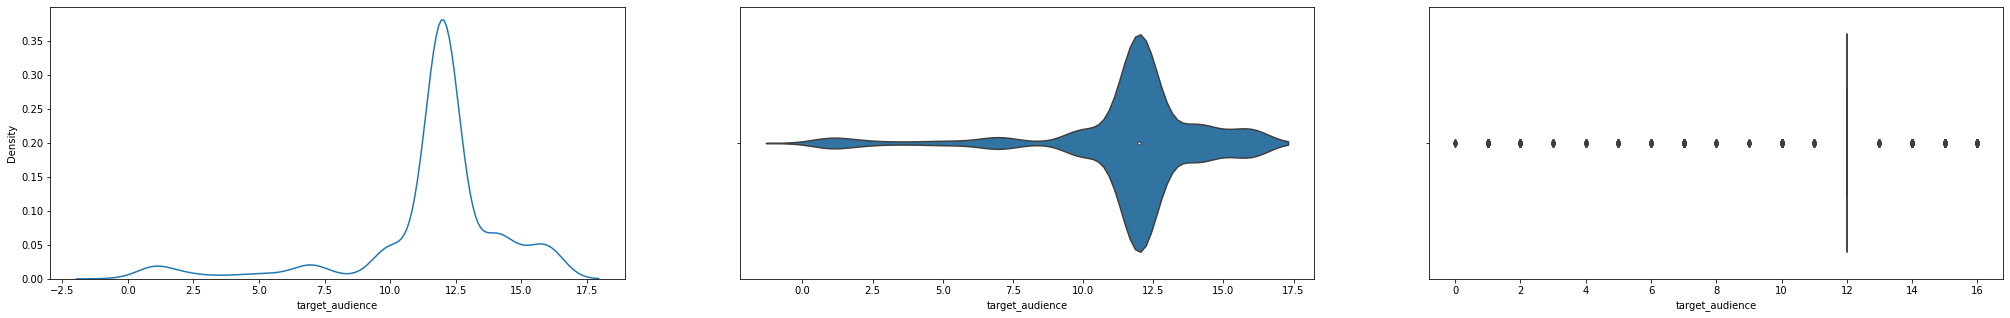

In [69]:
# target_audience
fig,axs= plt.subplots(ncols=3,figsize=(35,5))
sns.kdeplot(x.target_audience,ax=axs[0])
sns.violinplot(x.target_audience,ax=axs[1])
sns.boxplot(x.target_audience,ax=axs[2])

/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target_audience', ylabel='count'>

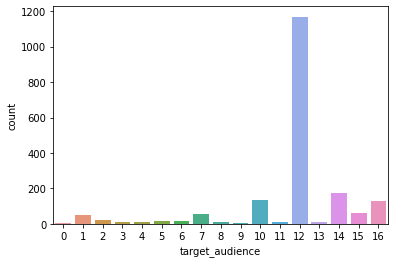

In [70]:
sns.countplot(x.target_audience)

In [71]:
x.target_audience= x.target_audience.apply(lambda x : 100 if x not in [10,12,14,15,16] else x)
df_test.target_audience= df_test.target_audience.apply(lambda x : 100 if x not in [10,12,14,15,16] else x)

In [72]:
x.target_audience = x.target_audience.astype('object')
df_test.target_audience = df_test.target_audience.astype('object')

/home/thecybermonster/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target_audience', ylabel='count'>

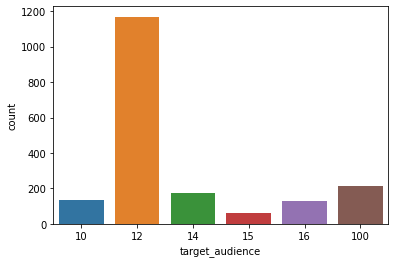

In [73]:
sns.countplot(x.target_audience)

In [74]:
dummy=pd.get_dummies(x['target_audience'],prefix='target_audience')
x=pd.concat([x,dummy],axis=1)
x.drop('target_audience',axis=1,inplace=True)

/home/thecybermonster/.local/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [75]:
dummy=pd.get_dummies(df_test['target_audience'],prefix='target_audience')
df_test=pd.concat([df_test,dummy],axis=1)
df_test.drop('target_audience',axis=1,inplace=True)

/home/thecybermonster/.local/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [76]:
x.head()

,subject_len,body_len,mean_paragraph_len,is_weekend,no_of_CTA,mean_CTA_len,is_personalised,is_discount,is_urgency,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,times_of_day_Evening,times_of_day_Morning,times_of_day_Noon,is_image_0,is_image_1,is_image_2,is_image_3,is_quote_0,is_quote_1,is_quote_2,is_quote_3,is_quote_100,is_emoticons_0,is_emoticons_1,sender_3,sender_10,sender_15,sender_100,category_1,category_2,category_6,category_9,category_10,category_15,category_100,product_1,product_5,product_6,product_9,product_11,product_13,product_23,product_26,product_31,product_34,product_42,product_100,target_audience_10,target_audience_12,target_audience_14,target_audience_15,target_audience_16,target_audience_100
0,76,10439,39,1,3,29,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,54,2570,256,1,0,22,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,59,12801,16,1,3,23,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3,74,11037,30,0,4,24,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,80,10011,27,1,3,31,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [77]:
x.shape

(1888, 59)

<AxesSubplot:>

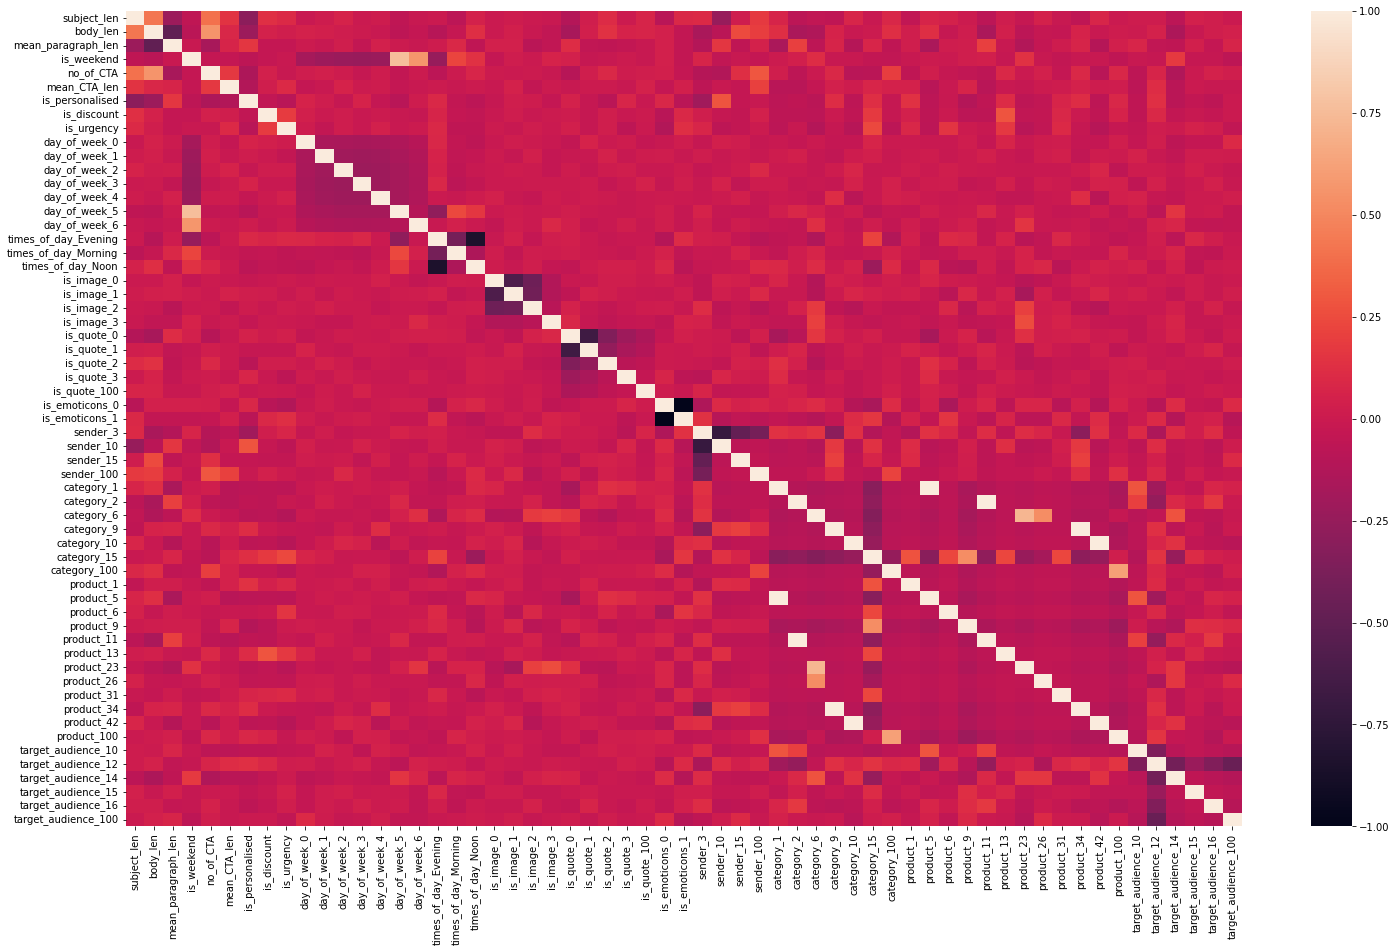

In [78]:
plt.figure(figsize=(25,15))
sns.heatmap(x.corr(),vmin= -1,vmax=1)

# Remove multi colinearty within the data

In [79]:
num_col=[]
for i in x.columns:
    if x[i].nunique() !=2:
        num_col.append(i)

In [80]:
num_col

['subject_len', 'body_len', 'mean_paragraph_len', 'no_of_CTA', 'mean_CTA_len']

In [81]:
print("numerical columns after mulit colinearity removal are :",num_col)

numerical columns after mulit colinearity removal are : ['subject_len', 'body_len', 'mean_paragraph_len', 'no_of_CTA', 'mean_CTA_len']


In [82]:
print("we have", len(num_col),"numerical columns")

we have 5 numerical columns


* we need to scale them

In [83]:
x[num_col].head()

,subject_len,body_len,mean_paragraph_len,no_of_CTA,mean_CTA_len
0,76,10439,39,3,29
1,54,2570,256,0,22
2,59,12801,16,3,23
3,74,11037,30,4,24
4,80,10011,27,3,31


<AxesSubplot:>

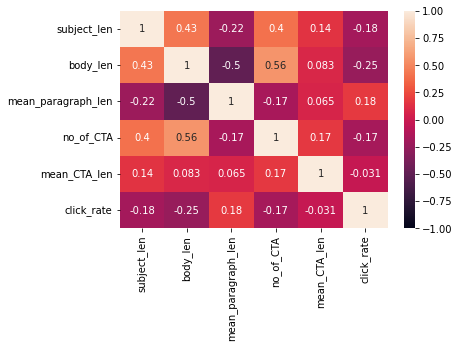

In [84]:
corr=pd.concat([x[num_col],y],axis=1)
corr=corr.corr()
sns.heatmap(corr,annot=True,vmax=1,vmin = -1)

/home/thecybermonster/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:>

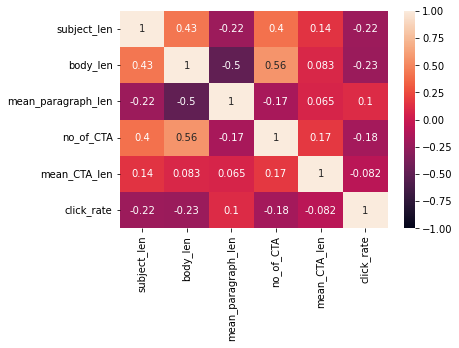

In [85]:
corr=pd.concat([x[num_col],np.log(y)],axis=1)
corr=corr.corr()
sns.heatmap(corr,annot=True,vmax=1,vmin = -1)

* there is no high coo-relation with meand Linear regression doesnt perform wel even after tranformting y column to normal distribution
* so we will build xgboost regression model
* XgBoost is capable of handling Mulit colinearty

In [86]:
x[num_col].head()

,subject_len,body_len,mean_paragraph_len,no_of_CTA,mean_CTA_len
0,76,10439,39,3,29
1,54,2570,256,0,22
2,59,12801,16,3,23
3,74,11037,30,4,24
4,80,10011,27,3,31


In [87]:
scale= StandardScaler()
x[num_col]=scale.fit_transform(x[num_col])
df_test[num_col]=scale.transform(df_test[num_col])

In [88]:
x[num_col].head()

,subject_len,body_len,mean_paragraph_len,no_of_CTA,mean_CTA_len
0,-0.340011,-0.511459,0.133676,-0.264194,-0.104094
1,-1.070053,-1.585626,7.847300,-0.912545,-0.695035
2,-0.904134,-0.189031,-0.683896,-0.264194,-0.610615
3,-0.406378,-0.429828,-0.186243,-0.048077,-0.526195
4,-0.207275,-0.569883,-0.292883,-0.264194,0.064746


In [89]:
df_test[num_col].head()

,subject_len,body_len,mean_paragraph_len,no_of_CTA,mean_CTA_len
0,-0.837767,-0.179476,-0.861630,-0.264194,0.571266
1,-1.070053,-1.585763,7.847300,-0.912545,-0.695035
2,0.058195,-1.735373,1.519996,-0.912545,-0.695035
3,0.058195,-1.735373,1.519996,-0.912545,-0.695035
4,-0.273643,-0.705161,-0.221790,-0.480311,0.824527


In [90]:
# PCA can handle multi colinearity so we will transform the entire data with multicolinearity
pca=PCA()

In [91]:
pca.fit(x)

PCA()

In [92]:
len(pca.explained_variance_ratio_)

59

In [93]:
np.round(pca.explained_variance_ratio_ ,4)

array([0.2081, 0.105 , 0.0715, 0.0632, 0.0475, 0.0399, 0.0356, 0.0347,
       0.0312, 0.0297, 0.0254, 0.0226, 0.0216, 0.0194, 0.018 , 0.0173,
       0.0168, 0.0156, 0.0151, 0.0143, 0.0128, 0.012 , 0.011 , 0.0109,
       0.0105, 0.0084, 0.0083, 0.0072, 0.0068, 0.0061, 0.0057, 0.0053,
       0.0051, 0.0045, 0.0042, 0.004 , 0.0037, 0.0036, 0.0034, 0.0032,
       0.0028, 0.0025, 0.0025, 0.0021, 0.0006, 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    ])

<AxesSubplot:>

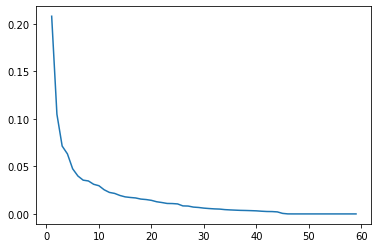

In [94]:
sns.lineplot(x=[i for i in range(1,60)],y=pca.explained_variance_ratio_)


In [95]:
# PCA can handle multi colinearity so we will transform the entire data with multicolinearity
pca=PCA(0.95)

In [96]:
pca.fit(x)

PCA(n_components=0.95)

In [97]:
len(pca.explained_variance_ratio_)

31

In [98]:
np.round(pca.explained_variance_ratio_ ,4)

array([0.2081, 0.105 , 0.0715, 0.0632, 0.0475, 0.0399, 0.0356, 0.0347,
       0.0312, 0.0297, 0.0254, 0.0226, 0.0216, 0.0194, 0.018 , 0.0173,
       0.0168, 0.0156, 0.0151, 0.0143, 0.0128, 0.012 , 0.011 , 0.0109,
       0.0105, 0.0084, 0.0083, 0.0072, 0.0068, 0.0061, 0.0057])

In [99]:
pac_data= pca.transform(x)

In [100]:
Y= np.log(y)
Y

/home/thecybermonster/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0      -2.272260
1      -0.356675
2      -5.889302
3      -4.521954
4      -1.946127
          ...   
1883   -1.047692
1884   -5.354225
1885   -4.792780
1886   -4.421715
1887   -5.614707
Name: click_rate, Length: 1888, dtype: float64

In [101]:
?XGBRegressor

Init signature:
XGBRegressor(
    *,
    objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'reg:squarederror',
    **kwargs: Any,
) -> None
Docstring:     
Implementation of the scikit-learn API for XGBoost regression.


Parameters
----------

    n_estimators : int
        Number of gradient boosted trees.  Equivalent to number of boosting
        rounds.

    max_depth :  Optional[int]
        Maximum tree depth for base learners.
    max_leaves :
        Maximum number of leaves; 0 indicates no limit.
    max_bin :
        If using histogram-based algorithm, maximum number of bins per feature
    grow_policy :
        Tree growing policy. 0: favor splitting at nodes closest to the node, i.e. grow
        depth-wise. 1: favor splitting at nodes with highest loss change.
    learning_rate : Optional[float]
        Boosting learning rate (xgb's "eta")
    verbosity : Optional[int]
        The degree of verbosity. Valid valu

In [102]:
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(x,y,test_size=0.2,random_state=42)
    
    # To select which parameters to optimize, please look at the XGBoost documentation:
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    param = {
        'lambda': trial.suggest_loguniform(
            'lambda', 1e-3, 10.0
        ),
        'alpha': trial.suggest_loguniform(
            'alpha', 1e-3, 10.0
        ),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'subsample': trial.suggest_categorical(
            'subsample', [0.6,0.7,0.8,1.0]
        ),
        'learning_rate': trial.suggest_float(
            'learning_rate', 0.001,0.4
        ),
        'n_estimators': trial.suggest_int(
            "n_estimators", 150,4000
        ),
        'max_depth': trial.suggest_categorical(
            'max_depth', [4,5,7,9,11,13,15,17]
        ),
        'random_state': 42,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        ),
    }
    model = XGBRegressor(**param)  
    model.set_params(early_stopping_rounds=100)
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],verbose=False)
    
    preds = model.predict(test_x)
    
    mae = mean_absolute_error(test_y, preds)
    #print(r2)
    return mae

In [103]:
study = optuna.create_study(direction='minimize')
study.optimize(objective,show_progress_bar=True,n_trials=250)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-08-07 12:59:29,455] A new study created in memory with name: no-name-d5f7ddea-bbd6-4b02-b62e-a984d873c601
/home/thecybermonster/.local/lib/python3.10/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-08-07 12:59:30,500] Trial 0 finished with value: 0.03543241245030321 and parameters: {'lambda': 0.0036855617164624965, 'alpha': 0.387737023338889, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.2833507763403312, 'n_estimators': 3537, 'max_depth': 4, 'min_child_weight': 152}. Best is trial 0 with value: 0.03543241245030321.
[I 2022-08-07 12:59:31,029] Trial 1 finished with value: 0.03841568259346679 and parameters: {'lambda': 0.003571220852629516, 'alpha': 0.06552871954879794, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.3615362319714157, 'n_estimators': 3097, 'max_depth': 11, 'min_child_weight': 213}. Best is trial 0 with value: 0.03543241245030321.
[I 2022-08-07 12:59:33,997] Trial 2 finished with value: 0.03776900573537702 and parameters: {'lambda': 0.014186875188798477, 'alpha': 0.11689401777863355, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.03555268938723621, 'n_estimators': 3094, 'max_depth': 7, 'min_child_weight': 219}. B

In [ ]:
# 0.5633683859736183
#params={'lambda': 0.015311581534899784, 'alpha': 0.001184792602113157, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.16734864054814122, 'n_estimators': 2000, 'max_depth': 19, 'min_child_weight': 53}

In [104]:
# rms  0.04546945700255865.
#params={'lambda': 2.516667908895054, 'alpha': 0.005662479324960345, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.2466907779941183, 'n_estimators': 200, 'max_depth': 20, 'min_child_weight': 59}

In [ ]:
#mse
#params= {'lambda': 2.5482467578467127, 'alpha': 0.010543549331554023, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.02423586659801208, 'n_estimators': 3000, 'max_depth': 14, 'min_child_weight': 1}

In [107]:
# mse
#params={'lambda': 8.245290407832472, 'alpha': 0.02005842343151029, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.18284853465775586, 'n_estimators': 3000, 'max_depth': 13, 'min_child_weight': 1}

In [104]:
# mse 0.026446392019721706.
params={'lambda': 9.993483170541582, 'alpha': 0.02234754741590284, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.00614994012757663, 'n_estimators': 3883, 'max_depth': 15, 'min_child_weight': 1}

In [105]:
model= XGBRegressor(**params)

In [106]:
model.fit(x,y)

XGBRegressor(alpha=0.02234754741590284, base_score=0.5, booster='gbtree',
             callbacks=None, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', lambda=9.993483170541582,
             learning_rate=0.00614994012757663, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=15, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=3883, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, ...)

In [107]:
y_pred=model.predict(df_test.drop('campaign_id',axis=1))

In [108]:
y_pred=y_pred.round(6)
y_pred

array([ 8.70230e-02,  6.75443e-01,  1.47835e-01,  1.75559e-01,
        1.56900e-01,  2.04000e-02,  2.35600e-03,  1.50830e-02,
       -2.50000e-04,  1.89020e-02,  2.60710e-02,  1.33350e-02,
        1.28130e-02,  1.17270e-02,  9.96300e-03,  1.05150e-02,
        9.16000e-03,  4.09400e-03,  1.62560e-02,  3.66860e-02,
        2.08730e-02,  5.45000e-03,  3.55200e-03,  1.19410e-02,
       -7.43000e-04, -1.97200e-03,  6.75310e-02,  9.23500e-03,
        9.28350e-02,  4.58300e-03,  2.18200e-03,  2.44060e-02,
        2.14000e-03,  8.71660e-02,  2.86880e-02,  1.01210e-02,
        2.58400e-03,  2.38700e-03,  3.73700e-03,  3.09800e-02,
        1.25530e-02,  1.73270e-02,  2.61200e-03,  6.37310e-02,
        5.99690e-02,  1.45400e-03,  1.81160e-02,  2.65520e-02,
        4.22920e-02,  1.13970e-02,  1.32200e-02,  1.45820e-02,
        4.25300e-03,  1.20970e-02,  5.70000e-03,  6.71900e-03,
        3.46490e-02,  4.02600e-03,  3.66300e-03,  3.38200e-03,
        7.47750e-02,  6.13500e-03,  2.14530e-02,  4.925

In [109]:
x_pred=model.predict(x)

In [110]:
x_pred

array([0.10228758, 0.6749211 , 0.00431809, ..., 0.00758762, 0.01148912,
       0.00535652], dtype=float32)

In [111]:
r2_score(y,x_pred)

0.9948827066694461

In [112]:
submission= pd.DataFrame()

In [113]:
submission["campaign_id"]=df_test.campaign_id

In [114]:
submission["click_rate"] = y_pred 

In [115]:
submission[submission['click_rate']<0]

,campaign_id,click_rate
8,1897,-0.000250
24,1913,-0.000743
25,1914,-0.001972
81,1970,-0.002309
93,1982,-0.002352
99,1988,-0.002591
104,1993,-0.003689
106,1995,-0.000840
124,2013,-0.001004
132,2021,-0.004735


In [116]:
submission.shape

(762, 2)

In [117]:
submission['click_rate']=submission['click_rate'].apply(lambda x: abs(x) if x<0 else x)

In [118]:
submission[submission['click_rate']<0]['click_rate']

Series([], Name: click_rate, dtype: float64)

In [119]:
submission.shape

(762, 2)

In [120]:
submission.to_csv("Submission-5.csv",index=False)

In [121]:
submission[submission['campaign_id'] == 2021]

,campaign_id,click_rate
132,2021,0.004735
